# Limits to Reservoir Learning
We're going to work through a numerical experiment for the work in https://arxiv.org/abs/2307.14474. Namely, we're going to pick a particular reservoir computer, and a particular learning task. We will first show that the power set of activation functions generally provides a large collection of useful functions, but then we will show that they help substantially less in the presence of noise.

# Echo State Networks

Let’s say we have a single input signal, and a single output signal. We map into the reservoir with an additional bias term, and we train on the output weights. What’s left is a random internal weight matrix, $W_{res}$ which has a spectral radius, and a bleed through which controls the reservoir’s memory. This model, while extremely simple, is now enough for us to study the impact of noise on the system! Moreover, it lives in a very general class of models, those with the eponymous echo state property. How do we characterize the system? First, we consider the input - U - the input to a system is treated as being drawn from some probability measure.


<div>
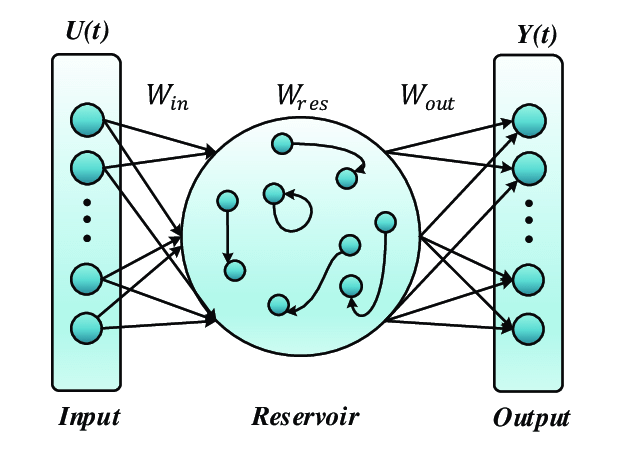
</div>
(Image from "Long-Short Term Echo State Network for Time Series Prediction" by Kaihong Zheng et al.)

Now, in the absence of noise, nearly any reservoir is good enough - you can orthogonalize the output, and the powerset of the output, and that gives you a collection of useful functions. Think, Gram-Schmidt.

This reservoir represents some function from some history to some output, namely f(x+1). That is, for some f representing the training data, the reservoir has some memory, and is now a function that maps f(-h)...f(-1) -> f(0). The reservoir can then be used to predict the next token, or the next $n$ tokens. One of these is patently easier, since you can just guess the last data point and be fairly close. Generating the next $n$ tokens is seemingly more difficult. 

It’s really doing a lot of data processing under the hood. But aside from these two tasks, is there some goal agnostic way to assess how well the network is learning? How much of this data processing is actually useful?
Here, the signal is extremely highly structured, given by, for instance, the solution to a differential equation. Instead of learning this function, we’ll start by looking at some signal characterized by some measure. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain, combinations
from functools import reduce

def ESN_init(inSize, outSize, resSize, alpha, sparsity):
    Win = np.random.rand(inSize+1, resSize)-0.5
    W = np.random.rand(resSize, resSize)-0.5
    W[np.random.rand(resSize, resSize)>sparsity] = 0
    spec_rad = max(abs(np.linalg.eig(W)[0]))
    W /= spec_rad
    return Win, W, inSize, resSize, alpha, sparsity

def reservoir(data, Win, W, inSize, resSize, alpha, restart):
    dm = np.zeros((data.shape[0], 1+inSize+resSize))
    if restart:
        R = .1*(np.ones((1, resSize)) - 0.5)
    for t in range(data.shape[0]):
        u = data[t]
        R = (1 - alpha)*R + alpha*np.tanh(np.dot(np.hstack((1,u)), Win) + np.dot(R, W))
        dm[t] = np.append(np.append(1,u), R)
    return dm

# The Task: NARMA10
NARMA is an acronym for Nonlinear AutoRegressive Moving Average. In the statistical analysis of time series, autoregressive–moving-average (ARMA) models provide a parsimonious description of a (weakly) stationary stochastic process in terms of two polynomials, one for the autoregression (AR) and the second for the moving average (MA). The general ARMA model was described in the 1951 thesis of Peter Whittle, Hypothesis testing in time series analysis, and it was popularized in the 1970 book by George E. P. Boxand Gwilym Jenkins.

It’s used to benchmark the performance of RNNs, especially ESNs.



In [4]:
def fetchData(n):
    while True:
        u = 0.5 * np.random.uniform(low=0., high=1.0, size=(n+1000))
        y_base = np.zeros(shape=(n+1000))
        y = np.zeros(shape=(n, 1))
        for i in range(10, n+1000):
            y_base[i] = 0.3 * y_base[i-1] + 0.05 * y_base[i-1] * np.sum(y_base[i-10:i]) + 1.5 * u[i-1] * u[i-10] + 0.1
        u = u[1000:]
        y[:, 0] = y_base[1000 : len(y_base)]
        if np.isfinite(y).all():
            return (u, y)

In [5]:
def test_NARMA10(inSize=1, outSize=1, train_cycles=10000, test_cycles=1000, alpha=0.7, resSize=5):    
    sparsity = 0.9
    Echo = ESN_init(inSize, outSize, resSize, alpha, sparsity)
    data_train, Y_train = fetchData(train_cycles+test_cycles)
    data_test, Y_test = fetchData(train_cycles+test_cycles)
    data_train, Y_train = data_train[:train_cycles], Y_train[:train_cycles]
    data_test, Y_test = data_test[train_cycles:], Y_test[train_cycles:]
    RA_Train = np.array(reservoir(data_train, *Echo))
    Wout = np.dot(np.linalg.pinv(RA_Train), Y_train)
    RA_Test = reservoir(data_test, *Echo)
    Yhat = np.dot(RA_Test, Wout)
    NRMSE = np.sqrt(np.divide(np.mean(np.square(Y_test[50:]-Yhat[50:])),np.var(Y_test[50:])))
    return NRMSE, Y_test, Yhat, RA_Test

0.7354638947307623


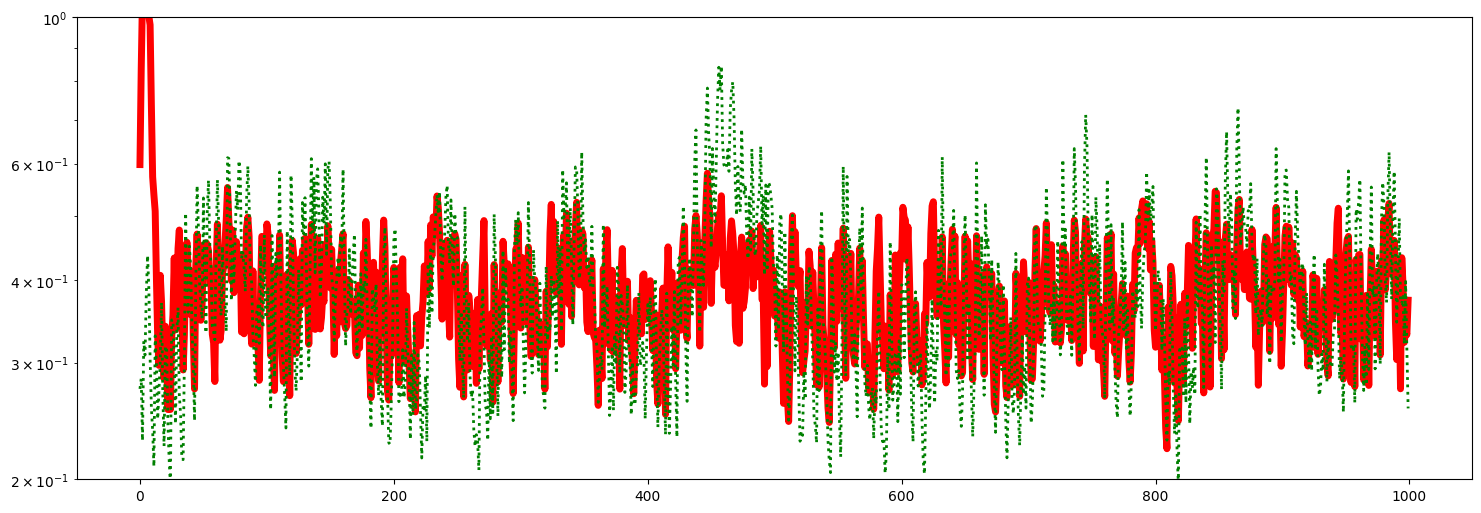

In [13]:
np.random.seed(137)
NRMSE, Y_test, Yhat, _ = test_NARMA10(resSize=5)
plt.figure(figsize=(18,6))
plt.yscale('log')
plt.plot(Yhat, color='red', linewidth=5, label='Single ESN Prediction')
plt.plot(Y_test, color='green', linestyle=":",  linewidth=2, label='Target Value')
plt.ylim(.2,1)
print(NRMSE)

This isn't too bad. Can we do better? We could increaae the reservoir size, or the training data - instead we will just add more signals from the activations we have, and see if that helps.

# Powerset Signals
Given some input signal, the learner is trying to make sense of the signal and process it in some way. In this work we consider the setting where we fix the network size, and instead consider engineering features. One reason we might do this is that making the network larger is either too expensive or slows down computation. I was motivated by quantum computation, where this is the case. Primarily, we are interested in understanding if the engineered features we consider can be useful.

But also, training with noise is expensive - you have to run the reservoir many times to get noise statistics! Either imagine a quantum computer, which requires many samples, or something like a self-driving car, receiving imperfect data from the world around it. Trials (the analog signal) can be noisy, and maybe the better thing to do is process the limited (and hence valuable) data.

Given $n$ neurons, a simple way to generate new features is to consider the pointwise products of the elements of the powerset. This multiplication produces linearly independent signals and is the simplest way I can think of for quickly creating a very large collection of signals. And in the deterministic setting, this works great, if we have a uniform prior about what the relevant signal to be learned is.

In [10]:
def reservoir(data, Win, W, inSize, resSize, alpha, restart=True, powerset=False):
    dm = np.zeros((data.shape[0], 1+inSize+resSize))
    if restart:
        R = .1*(np.ones((1, resSize)) - 0.5)
    for t in range(data.shape[0]):
        u = data[t]
        R = (1 - alpha)*R + alpha*np.tanh(np.dot(np.hstack((1,u)), Win) + np.dot(R, W))
        dm[t] = np.append(np.append(1,u), R)
    num_points = dm.shape[0]
    if not powerset:
        return dm
    else:
        s = list(dm.T)[2:]
        power_signals = [reduce(lambda a, b: a*b, el, np.ones(num_points)) for el in list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))[1:]]
        power_signals = list(dm.T)[0:2] + power_signals
        return np.array(power_signals).T
    
def test_NARMA10(inSize=1, outSize=1, train_cycles=10000, test_cycles=1000, alpha=0.7, resSize=5, powerset=False):    
    sparsity = 0.9
    Echo = ESN_init(inSize, outSize, resSize, alpha, sparsity)
    data_train, Y_train = fetchData(train_cycles+test_cycles)
    data_test, Y_test = fetchData(train_cycles+test_cycles)
    data_train, Y_train = data_train[:train_cycles], Y_train[:train_cycles]
    data_test, Y_test = data_test[train_cycles:], Y_test[train_cycles:]
    Yhats = []
    RA_Trains = []
    RA_Train = np.array(reservoir(data_train, *Echo, powerset))
    coeff = 1E-2
    ridge = np.zeros(RA_Train.shape)
    np.fill_diagonal(ridge, coeff)   
    Wout = np.dot(np.linalg.pinv(RA_Train + ridge), Y_train)   
    RA_Test = reservoir(data_test, *Echo, powerset)
    Yhat = np.dot(RA_Test, Wout)
    NRMSE = np.sqrt(np.divide(np.mean(np.square(Y_test[50:]-Yhat[50:])),np.var(Y_test[50:])))
    return NRMSE, Y_test, Yhat, RA_Test

0.5949314459089521


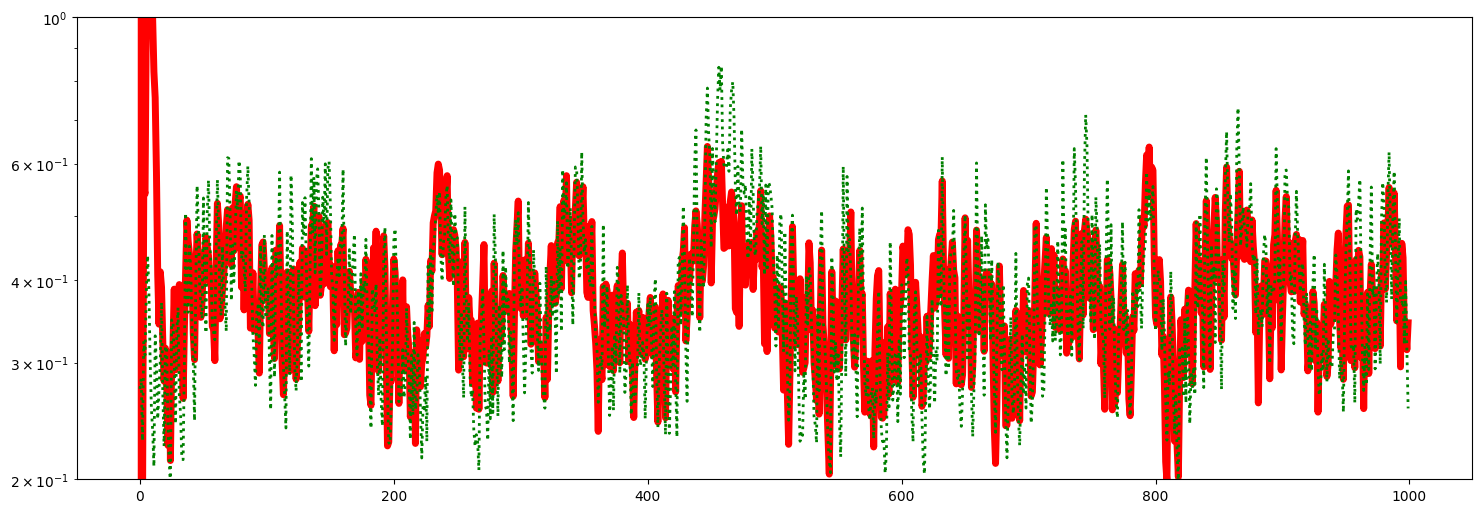

In [14]:
np.random.seed(137)
NRMSE, Y_test, Yhat, activations = test_NARMA10(resSize=5, powerset=True)
plt.figure(figsize=(18,6))
plt.yscale('log')
plt.plot(Yhat, color='red', linewidth=5, label='Single ESN Prediction')
plt.plot(Y_test, color='green', linestyle=":",  linewidth=2, label='Target Value')
plt.ylim(.2,1)
print(NRMSE)

It helps! We've improved from 0.735 to 0.595. We will be more careful to optimize the later so we can be more confident in this increase.

# Let's look at the activations, and their power set.

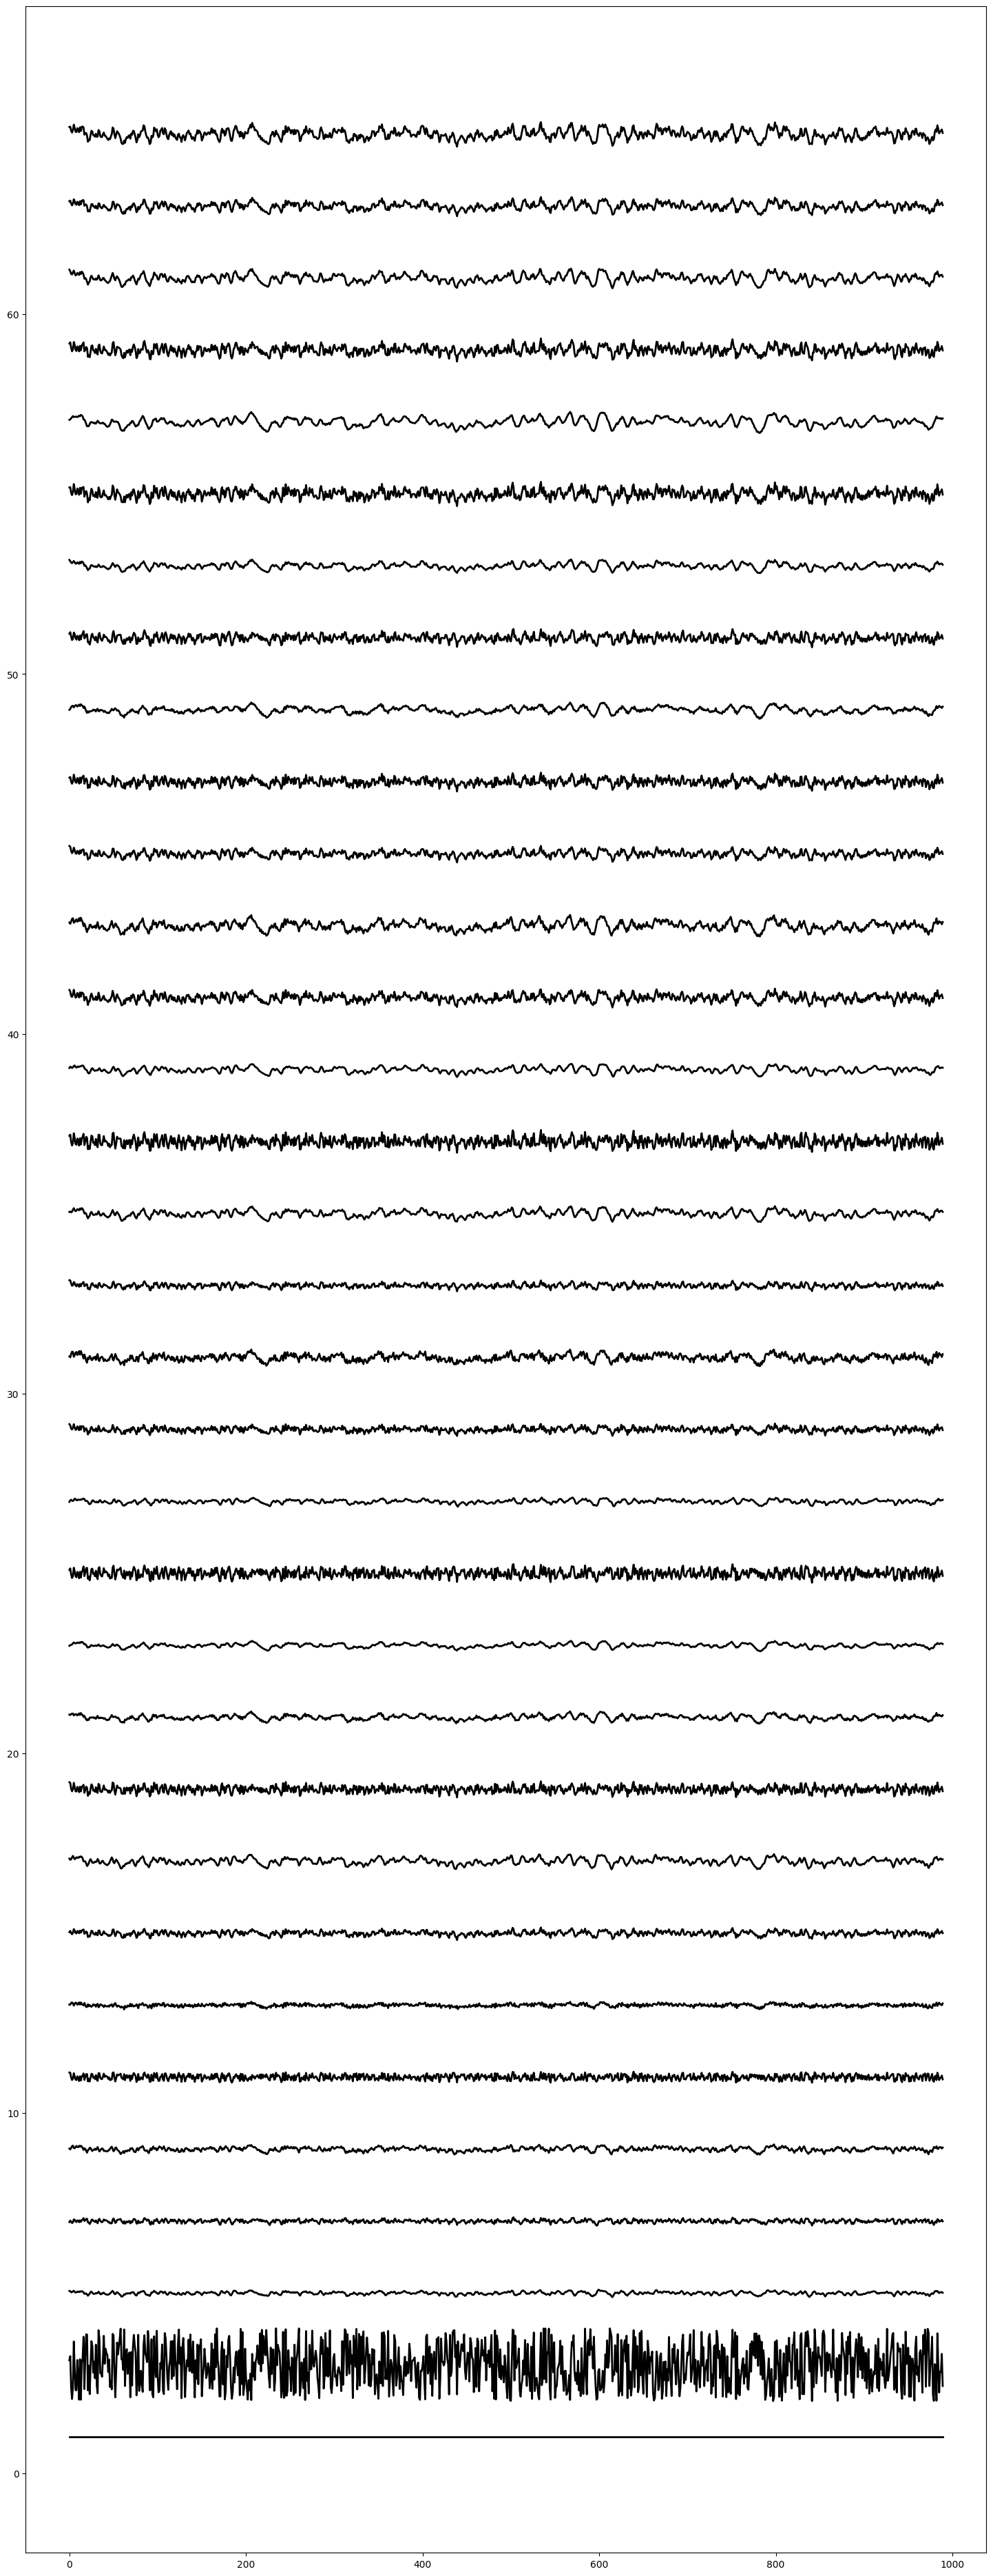

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def rms_diff(signal1, signal2):
    return np.sqrt(np.mean((signal1 - signal2)**2))

plt.figure(figsize=(18,48))

signals = np.abs(activations).T
signals = [signal / np.max(signal) for signal in signals]
epsilon = 0.001  # set your epsilon
filtered_signals = []

for i in range(len(signals)):
    if all(rms_diff(signals[i][10:], signals[j][10:]) > epsilon for j in range(len(signals)) if i != j):
        filtered_signals.append(signals[i])

shift = 0
for signal in filtered_signals:
    new_signal = signal[10:]/np.max(signal)
    shifted_signal = new_signal/np.average(new_signal[10:]) + shift
    plt.plot(shifted_signal, color='k', linestyle="-", linewidth=2)
    shift += 2  # increase shift for each signal

plt.show()

The product signals are naturally smaller, so we have scaled them. We can orthogonalize this set with Gram-Schmidt.

In [18]:
import numpy as np
def gs_cofficient(v1, v2):
    return np.dot(v2, v1) / np.dot(v1, v1)

def multiply(cofficient, v):
    return map((lambda x : x * cofficient), v)

def proj(v1, v2):
    return multiply(gs_cofficient(v1, v2) , v1)

def gs(X):
    Y = []
    for i in range(len(X)):
        temp_vec = X[i]
        for inY in Y :
            proj_vec = proj(inY, X[i])
            temp_vec = list(map(lambda x, y : x - y, temp_vec, proj_vec))
        Y.append(temp_vec)
    return np.array(Y)

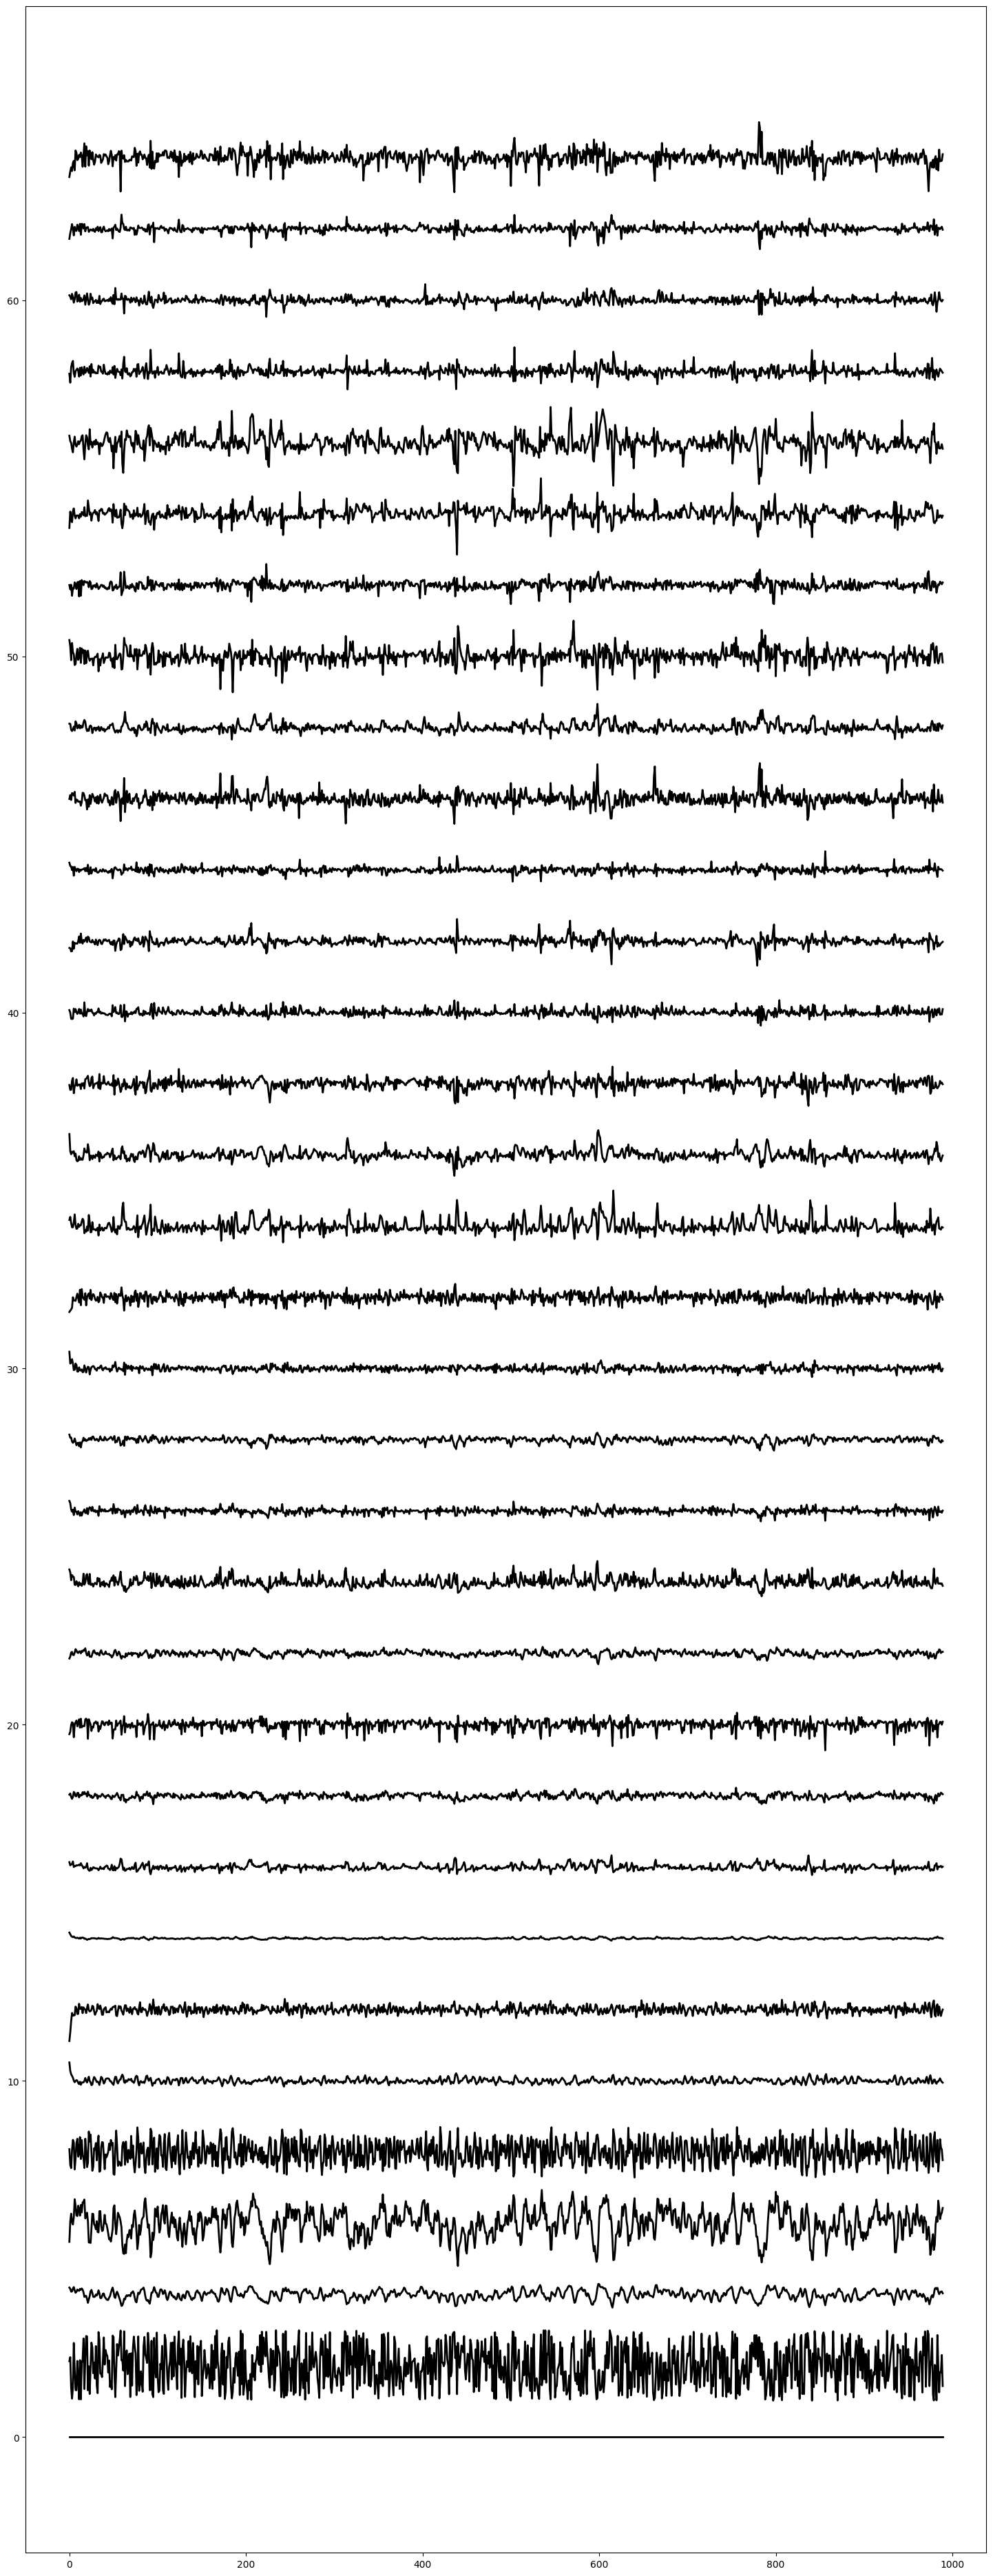

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def rms_diff(signal1, signal2):
    return np.sqrt(np.mean((signal1 - signal2)**2))

plt.figure(figsize=(18,48))

orthogonal_signals =  gs(signals)
orthogonal_filtered_signals = []
for i in range(len(orthogonal_signals)):
    if all(rms_diff(signals[i][10:], signals[j][10:]) > epsilon for j in range(len(signals)) if i != j):
        orthogonal_filtered_signals.append(orthogonal_signals[i])

shift = 0
for signal in orthogonal_signals:
    normalized_signal = signal[10:]/np.max(signal) 
    shifted_signal = normalized_signal  - np.average(normalized_signal[10:]) + shift    
    plt.plot(shifted_signal, color='k', linestyle="-", linewidth=2)
    shift += 2  # increase shift for each signal

plt.show()